# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## Support functions and variables

In [2]:
#!unzip ml-100k.zip -d .

In [3]:
MOVIELENS_DIR = "ml-100k"

In [4]:
!ls {MOVIELENS_DIR}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [6]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


In [8]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Q1

### (a)

In [9]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    return matrix    
    
    
    
    ###########         end         ###########
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [11]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # Extract the items the user already rated
                userVector = train_matrix[user, :]
                ratedItems = userVector[userVector.nonzero()]
            
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
    
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
            
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
            
            
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [12]:
popularity_recsys = BaseLineRecSys('popularity')

In [13]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [14]:
x = popularity_recsys.getModel()

In [15]:
np.all(x<=1)

True

In [16]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:39, 2550.03it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [18]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [19]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [20]:
average_user_rating_recsys.getModel()

array([[ 0.        ,  0.        ,  0.        , ...,  3.61029412,
         3.61029412,  3.61029412],
       [ 0.        ,  3.70967742,  3.70967742, ...,  3.70967742,
         3.70967742,  3.70967742],
       [ 2.7962963 ,  2.7962963 ,  2.7962963 , ...,  2.7962963 ,
         2.7962963 ,  2.7962963 ],
       ..., 
       [ 0.        ,  4.04545455,  4.04545455, ...,  4.04545455,
         4.04545455,  4.04545455],
       [ 4.26582278,  4.26582278,  4.26582278, ...,  4.26582278,
         4.26582278,  4.26582278],
       [ 3.41071429,  0.        ,  3.41071429, ...,  3.41071429,
         3.41071429,  3.41071429]])

In [21]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:39, 2536.43it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [22]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='euclidean'))
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        
        
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='manhattan'))

    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            
            if self.method_name == "cosine":
                uu_similarity = self.cosine(train_matrix)
            elif self.method_name == "euclidean":
                uu_similarity =  self.euclidean(train_matrix)
            else:
                uu_similarity =  self.somethingelse(train_matrix)
                
                
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start

            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########

            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            
            #transpose train_matrix into a item-user matrix
            train_matrix_T= np.transpose(train_matrix)
            
            if self.method_name == "cosine":
                ii_similarity = self.cosine(train_matrix_T)
            elif self.method_name == "euclidean":
                ii_similarity =  self.euclidean(train_matrix_T)
            else:
                ii_similarity =  self.somethingelse(train_matrix_T)
            
            normalizer = np.matmul(temp_matrix,ii_similarity)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(train_matrix, ii_similarity)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start

            itemaverage = np.sum(train_matrix, axis=0)/np.sum(temp_matrix, axis=0)
            rows = np.sum(predictionMatrix, axis=1)
            predictionMatrix[rows == 0,:] = predictionMatrix[rows == 0,:] + np.expand_dims(itemaverage, axis=0)
            self.__model = predictionMatrix
            
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [23]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [24]:
SimBasedRecSys.euclidean(I)

array([[ 1.        ,  0.41421356,  0.41421356],
       [ 0.41421356,  1.        ,  0.41421356],
       [ 0.41421356,  0.41421356,  1.        ]])

In [25]:
SimBasedRecSys.somethingelse(I)

array([[ 1.        ,  0.33333333,  0.33333333],
       [ 0.33333333,  1.        ,  0.33333333],
       [ 0.33333333,  0.33333333,  1.        ]])

### (b)

The metric I chose is the Manhattan metric, it is simply just the absolute distance of the item between two users, which performs faster on large user-item matrix.

## Q3

### (a)

In [26]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [27]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [28]:
user_cosine_recsys.getModel()

array([[ 3.89911175,  3.19022667,  3.0261129 , ...,  2.        ,
         3.        ,  3.        ],
       [ 3.84034456,  3.17139889,  2.92626717, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.87104065,  3.12823798,  3.03250708, ...,  2.        ,
         3.        ,  3.        ],
       ..., 
       [ 3.90754645,  3.20227238,  3.05776201, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.91100649,  3.21591021,  2.98854017, ...,  2.        ,
         3.        ,  3.        ],
       [ 3.91593122,  3.24268207,  3.08255897, ...,  0.        ,
         3.        ,  3.        ]])

In [29]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [30]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:37, 2661.42it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [31]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [32]:
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [33]:
item_cosine_recsys.getModel()

array([[ 3.75429099,  3.66419957,  3.73222997, ...,  3.60248287,
         3.79662696,  3.90232044],
       [ 3.83658867,  3.80424519,  3.77473905, ...,  3.72798332,
         3.9109779 ,  3.79775927],
       [ 2.84492718,  2.89389328,  2.84327324, ...,  2.99504451,
         3.16444153,  2.9858119 ],
       ..., 
       [ 4.11427954,  4.0558267 ,  4.00963139, ...,  4.        ,
         3.87872799,  4.14814803],
       [ 4.37096823,  4.39679254,  4.33543016, ...,  3.955358  ,
         4.41891089,  4.57995134],
       [ 3.52030345,  3.46948821,  3.52393064, ...,  0.        ,
         3.6110641 ,  3.59656861]])

In [34]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [35]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:37, 2639.53it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [36]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [37]:
# How to use CrossValidation Class?

In [38]:
# 1. gather your algorithms in previous steps.
#algorithm_instances = [popularity_recsys, 
#                       average_user_rating_recsys, 
#                       user_cosine_recsys]

In [39]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
#cv_patk = CrossValidation('P@K')

In [40]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
#cv_patk.run(algorithm_instances, num_users, num_items,k=5)

In [41]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Use RMSE
cv_rmse= CrossValidation('RMSE')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
RMSE = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:05, 3402.91it/s]
20000it [00:06, 3311.44it/s]
20000it [00:05, 3410.46it/s]
20000it [00:05, 3452.46it/s]
20000it [00:06, 3322.16it/s]


Processing algorithm item-cosine


C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3392.01it/s]
20000it [00:05, 3407.83it/s]
20000it [00:06, 3286.89it/s]
20000it [00:05, 3370.13it/s]
20000it [00:05, 3421.12it/s]


In [42]:
a = RMSE['item-cosine'][1]
ci = RMSE['item-cosine'][2:4]
print("For item-item, the mean is " + str(a))
print("For item-item, the 95% confidence interval is " + str(ci))

For item-item, the mean is 1.02008290011
For item-item, the 95% confidence interval is [1.006824268625073, 1.0333415315874224]


In [43]:
a = RMSE['user-cosine'][1]
ci = RMSE['user-cosine'][2:4]
print("For user-user, the mean is " + str(a))
print("For user-user. the 95% confidence interval is " + str(ci))

For user-user, the mean is 1.01735412166
For user-user. the 95% confidence interval is [1.0090130802261481, 1.0256951630950135]


The average number of rating per user is sligtly lower than the average number of rating per item, which means user-user collaborative filtering with cosine similarity is more accuracte. This is because item-item is larger in size.

## Q4

### (a)

# CrossValidation at RMSE

In [44]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Use RMSE
cv_rmse= CrossValidation('RMSE')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
RMSE = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3346.21it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3256.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3347.99it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3280.40it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3413.42it/s]


Processing algorithm useraverage


20000it [00:05, 3384.85it/s]
20000it [00:06, 3299.88it/s]
20000it [00:06, 3298.02it/s]
20000it [00:05, 3394.10it/s]
20000it [00:05, 3360.50it/s]


Processing algorithm user-cosine


20000it [00:05, 3361.30it/s]
20000it [00:05, 3406.62it/s]
20000it [00:05, 3353.51it/s]
20000it [00:05, 3384.61it/s]
20000it [00:05, 3377.45it/s]


Processing algorithm item-cosine


C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3324.41it/s]
20000it [00:06, 3206.84it/s]
20000it [00:05, 3380.89it/s]
20000it [00:05, 3407.86it/s]
20000it [00:05, 3379.02it/s]


In [45]:
print("For RMSE item-cosine, the mean is " + str(RMSE['item-cosine'][1]))
print("For RMSE item-cosine, the 95% confidence interval is " + str(RMSE['item-cosine'][2:4]))

print("For RMSE popularity, the mean is " + str(RMSE['popularity'][1]))
print("For RMSE popularity, the 95% confidence interval is " + str(RMSE['popularity'][2:4]))
      
print("For RMSE user-cosine, the mean is " + str(RMSE['user-cosine'][1]))
print("For RMSE user-cosine, the 95% confidence interval is " + str(RMSE['user-cosine'][2:4]))
      
print("For RMSE useraverage, the mean is " + str(RMSE['useraverage'][1]))
print("For RMSE useraverage, the 95% confidence interval is " + str(RMSE['useraverage'][2:4]))

For RMSE item-cosine, the mean is 1.02008290011
For RMSE item-cosine, the 95% confidence interval is [1.006824268625073, 1.0333415315874224]
For RMSE popularity, the mean is 3.15909289099
For RMSE popularity, the 95% confidence interval is [3.1392927469953871, 3.1788930349826354]
For RMSE user-cosine, the mean is 1.01735412166
For RMSE user-cosine, the 95% confidence interval is [1.0090130802261481, 1.0256951630950135]
For RMSE useraverage, the mean is 1.04371765616
For RMSE useraverage, the 95% confidence interval is [1.0289303496379316, 1.0585049626810734]


# Crossvalidation with P@K

In [46]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Use P@K
cv_patk= CrossValidation('P@K')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
PATK = cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3432.49it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3440.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3414.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3384.12it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3367.62it/s]


Processing algorithm useraverage


20000it [00:06, 3296.26it/s]
20000it [00:05, 3466.02it/s]
20000it [00:06, 3300.25it/s]
20000it [00:05, 3396.19it/s]
20000it [00:05, 3372.33it/s]


Processing algorithm user-cosine


20000it [00:05, 3427.82it/s]
20000it [00:06, 3240.74it/s]
20000it [00:06, 3254.58it/s]
20000it [00:05, 3378.65it/s]
20000it [00:06, 3322.87it/s]


Processing algorithm item-cosine


C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3437.82it/s]
20000it [00:05, 3405.85it/s]
20000it [00:05, 3365.85it/s]
20000it [00:06, 3326.59it/s]
20000it [00:06, 3323.38it/s]


In [47]:
print("For PATK item-cosine, the mean is " + str(PATK['item-cosine'][1]))
print("For PATK item-cosine, the 95% confidence interval is " + str(PATK['item-cosine'][2:4]))

print("For PATK popularity, the mean is " + str(PATK['popularity'][1]))
print("For PATK popularity, the 95% confidence interval is " + str(PATK['popularity'][2:4]))
      
print("For PATK user-cosine, the mean is " + str(PATK['user-cosine'][1]))
print("For PATK user-cosine, the 95% confidence interval is " + str(PATK['user-cosine'][2:4]))
      
print("For PATK useraverage, the mean is " + str(PATK['useraverage'][1]))
print("For PATK useraverage, the 95% confidence interval is " + str(PATK['useraverage'][2:4]))

For PATK item-cosine, the mean is 0.532216330859
For PATK item-cosine, the 95% confidence interval is [0.38370052150098888, 0.6807321402169354]
For PATK popularity, the mean is 0.550583244963
For PATK popularity, the 95% confidence interval is [0.40544114481568705, 0.69572534511008388]
For PATK user-cosine, the mean is 0.555843054083
For PATK user-cosine, the 95% confidence interval is [0.40959849499983714, 0.70208761316559432]
For PATK useraverage, the mean is 0.473637327678
For PATK useraverage, the 95% confidence interval is [0.34199930134510592, 0.60527535401014587]


# Crossvalidation with R@K

In [48]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Use R@K
cv_ratk= CrossValidation('R@K')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
RATK = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3351.32it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3309.66it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3357.13it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3386.12it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3425.38it/s]


Processing algorithm useraverage


20000it [00:06, 3240.74it/s]
20000it [00:05, 3363.37it/s]
20000it [00:05, 3392.04it/s]
20000it [00:06, 3276.84it/s]
20000it [00:05, 3379.33it/s]


Processing algorithm user-cosine


20000it [00:05, 3347.48it/s]
20000it [00:05, 3406.10it/s]
20000it [00:05, 3419.78it/s]
20000it [00:05, 3410.82it/s]
20000it [00:05, 3345.98it/s]


Processing algorithm item-cosine


C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide
20000it [00:05, 3389.12it/s]
20000it [00:06, 3300.17it/s]
20000it [00:06, 3287.09it/s]
20000it [00:06, 3255.97it/s]
20000it [00:06, 3317.31it/s]


In [49]:
print("For RATK item-cosine, the mean is " + str(RATK['item-cosine'][1]))
print("For RATK item-cosine, the 95% confidence interval is " + str(RATK['item-cosine'][2:4]))

print("For RATK popularity, the mean is " + str(RATK['popularity'][1]))
print("For RATK popularity, the 95% confidence interval is " + str(RATK['popularity'][2:4]))
      
print("For RATK user-cosine, the mean is " + str(RATK['user-cosine'][1]))
print("For RATK user-cosine, the 95% confidence interval is " + str(RATK['user-cosine'][2:4]))
      
print("For RATK useraverage, the mean is " + str(RATK['useraverage'][1]))
print("For RATK useraverage, the 95% confidence interval is " + str(RATK['useraverage'][2:4]))

For RATK item-cosine, the mean is 0.474971114859
For RATK item-cosine, the 95% confidence interval is [0.35357317503649865, 0.59636905468163459]
For RATK popularity, the mean is 0.484075887884
For RATK popularity, the 95% confidence interval is [0.36713736297983229, 0.60101441278890522]
For RATK user-cosine, the mean is 0.486268723554
For RATK user-cosine, the 95% confidence interval is [0.36944736109872178, 0.60309008600856562]
For RATK useraverage, the mean is 0.441323205022
For RATK useraverage, the 95% confidence interval is [0.32931026359142457, 0.5533361464534351]


### (b)

RMSE doesn't work with popularity based recommendation since popularity is an output of number of user liked over number of user rated, however, the ratings are from 1-5. This means that the RMSE is very large in this case.

### (c)

For RMSE, best accuracy is user-cosine. For P@k, best accuracy is user-cosine. For R@k, best accyracy is user-cosine as well. 

### (d)

No. Perfect RMSE implies perfect ranking, but good RMSE is not required for good ranking. Unlike ranking, which focuses more
on high-scoring items, RMSE places equal emphasis on high and low ratings. For example, (3.5,3.7) is same as (1.1,1.3)

## Q5

### (a)

In [50]:
# Get the data of different move types
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### From movie list, the three movies I chose are Die Hard, Alien and  The Godfather

In [51]:
moviesDF_matrix = moviesDF.values

In [52]:
moviesDF_matrix

array([[1, 'Toy Story (1995)', '01-Jan-1995', ..., 0, 0, 0],
       [2, 'GoldenEye (1995)', '01-Jan-1995', ..., 1, 0, 0],
       [3, 'Four Rooms (1995)', '01-Jan-1995', ..., 1, 0, 0],
       ..., 
       [1680, 'Sliding Doors (1998)', '01-Jan-1998', ..., 0, 0, 0],
       [1681, 'You So Crazy (1994)', '01-Jan-1994', ..., 0, 0, 0],
       [1682, 'Scream of Stone (Schrei aus Stein) (1991)', '08-Mar-1996',
        ..., 0, 0, 0]], dtype=object)

In [53]:
movies_types = moviesDF_matrix[:,6:]
movies_types

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [54]:
cos_sim_movies = SimBasedRecSys.cosine(movies_types)

In [55]:
cos_sim_movies

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.57735027,  0.        ],
       [ 0.        ,  1.        ,  0.57735027, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.57735027,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.70710678],
       [ 0.57735027,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.70710678,
         0.        ,  1.        ]])

# First movie I chose is Die Hard(1988) index 143

In [56]:
n = 143
sim_movies = cos_sim_movies.argsort()[n][-5:]
print(moviesDF_matrix[n,1])

Die Hard (1988)


In [57]:
# Select movie I want to compare with, n=143, Die Hard
n = 143
sim_movies = cos_sim_movies.argsort()[n][-5:]
top5_sim_movies = []

for i in range(5):
    movie_name = moviesDF_matrix[sim_movies[i],1]
    top5_sim_movies.append(movie_name)
top5_sim_movies

['Broken Arrow (1996)',
 'Die Hard: With a Vengeance (1995)',
 'Hunt for Red October, The (1990)',
 'Glimmer Man, The (1996)',
 'Die Hard (1988)']

# Second movie I chose is Alien(1979) index 182

In [58]:
n = 182
sim_movies = cos_sim_movies.argsort()[n][-5:]
print(moviesDF_matrix[n,1])

Alien (1979)


In [59]:
# Select movie I want to compare with, n=182, Alien
n = 182
sim_movies = cos_sim_movies.argsort()[n][-5:]
top5_sim_movies = []

for i in range(5):
    movie_name = moviesDF_matrix[sim_movies[i],1]
    top5_sim_movies.append(movie_name)
top5_sim_movies

['Terminator 2: Judgment Day (1991)',
 'Body Snatchers (1993)',
 'Johnny Mnemonic (1995)',
 'Alien 3 (1992)',
 'Alien (1979)']

# Third movie I chose is Godfather(1972) index 126

In [60]:
n = 126
sim_movies = cos_sim_movies.argsort()[n][-5:]
print(moviesDF_matrix[n,1])

Godfather, The (1972)


In [61]:
# Select movie I want to compare with, n=126, The Godfather 
n = 126
sim_movies = cos_sim_movies.argsort()[n][-5:]
top5_sim_movies = []

for i in range(5):
    movie_name = moviesDF_matrix[sim_movies[i],1]
    top5_sim_movies.append(movie_name)
top5_sim_movies

['Lashou shentan (1992)',
 'Dead Presidents (1995)',
 'Godfather, The (1972)',
 'Godfather: Part II, The (1974)',
 'Menace II Society (1993)']

### (b)

Yes.The movies I chose are ones that have sequels and most of the time they have the same movie types,  so the item-item cosine similarites can successfully find these similar movies. Same for the other ones with similar movie types.

## Q6 [GRAD ONLY]

### (a)

In [62]:
userID_series=rating_df['userID'].value_counts()

In [63]:
userID_list = list(userID_series.keys())
num_user_ratings = list(userID_series.values)

In [64]:
hist_list = []
for i,j in userID_series.items():
    temp = []
    temp = [i] * j
    hist_list = hist_list + temp

In [65]:
result = plt.hist(hist_list,bins=range(1,len(userID_series.keys())+2))

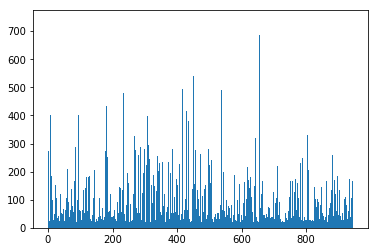

In [66]:
plt.show()

In [67]:
median = np.median([result[0]])

In [68]:
above_tau = []
below_tau = []
for i in range(0,len(result[0])):
    if result[0][i] < median:
        below_tau.append(result[1][i])
    else:
        above_tau.append(i)

In [69]:
above_tau_user = rating_df[rating_df['userID'].isin(above_tau)]
below_tau_user = rating_df[rating_df['userID'].isin(below_tau)]

In [70]:
above_tau_user.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
2,22,377,1,878887116
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488


In [71]:
below_tau_user.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
4,166,346,1,886397596
16,122,387,5,879270459
30,50,246,3,877052329
32,225,193,4,879539727


## For above tau dataframe, perform user-user filtering

In [72]:
dataPreprocessor(above_tau_user, num_users, num_items)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [73]:
user_cosine_recsys = SimBasedRecSys('user','cosine')
user_cosine_recsys.predict_all(above_tau_user, num_users, num_items)
user_cosine_recsys.getModel()

C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,         nan],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,         nan],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,         nan],
       ..., 
       [ 3.92892945,  3.1484334 ,  3.14474632, ...,  2.        ,
         3.        ,  4.04545455],
       [ 3.86440178,  3.17124041,  3.04628231, ...,  2.        ,
         3.        ,  4.26582278],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,         nan]])

## For above tau dataframe, perform item-item filtering

In [74]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(above_tau_user, num_users, num_items)
item_cosine_recsys.getModel()

C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


array([[ 3.86419753,  3.16176471,  3.125     , ...,  2.        ,
         3.        ,         nan],
       [ 3.86419753,  3.16176471,  3.125     , ...,  2.        ,
         3.        ,         nan],
       [ 3.86419753,  3.16176471,  3.125     , ...,  2.        ,
         3.        ,         nan],
       ..., 
       [ 4.12706779,  4.05428605,  4.02748352, ...,  4.        ,
         3.87960043,  0.        ],
       [ 4.37276508,  4.39621686,  4.38093345, ...,  3.95282482,
         4.42195074,  0.        ],
       [ 3.86419753,  3.16176471,  3.125     , ...,  2.        ,
         3.        ,         nan]])

## Perform cross-validation with new cross_validation function

In [75]:
class NewCrossValidation(object):
    def __init__(self, metric, test):
        """
            INPUT:
                metric: string. from['RMSE']
        """
        
        data_path=MOVIELENS_DIR
        
        self.test = test
        self.folds = self._getData(MOVIELENS_DIR,self.test)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    

    @staticmethod
    def getMatrix(above_tau_user, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path, test):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            
            if test == 'above_df':
                test_set = test_set[test_set['userID'].isin(above_tau_user['userID'])]
            else:
                test_set = test_set[test_set['userID'].isin(below_tau_user['userID'])]
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [76]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Use RMSE
cv_rmse= NewCrossValidation('RMSE','above')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
RMSE = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


3179it [00:00, 3715.54it/s]
3221it [00:00, 3692.89it/s]
3471it [00:00, 3683.86it/s]
3513it [00:00, 3557.78it/s]
3582it [00:01, 3535.17it/s]


Processing algorithm item-cosine


C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide
3179it [00:00, 3665.84it/s]
3221it [00:00, 3585.97it/s]
3471it [00:00, 3600.71it/s]
3513it [00:01, 3409.85it/s]
3582it [00:01, 3338.54it/s]


In [77]:
a = RMSE['item-cosine'][1]
ci = RMSE['item-cosine'][2:4]
print("For above tau item-item, the mean is " + str(a))
print("For above tau item-item, the 95% confidence interval is " + str(ci))

For above tau item-item, the mean is 1.03685552383
For above tau item-item, the 95% confidence interval is [1.0301873105766832, 1.0435237370771118]


In [78]:
a = RMSE['user-cosine'][1]
ci = RMSE['user-cosine'][2:4]
print("For above tau user-user, the mean is " + str(a))
print("For above tau user-user. the 95% confidence interval is " + str(ci))

For above tau user-user, the mean is 1.05279505176
For above tau user-user. the 95% confidence interval is [1.0361439502535021, 1.0694461532643094]


## For below tau dataframe, perform user-user filtering

In [79]:
dataPreprocessor(below_tau_user, num_users, num_items)

array([[0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [80]:
user_cosine_recsys = SimBasedRecSys('user','cosine')
user_cosine_recsys.predict_all(below_tau_user, num_users, num_items)
user_cosine_recsys.getModel()

C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 3.87327884,  3.        ,  3.36462318, ...,  3.70967742,
         3.70967742,  3.70967742],
       [ 3.89190744,  3.        ,  3.72767284, ...,  2.7962963 ,
         2.7962963 ,  2.7962963 ],
       ..., 
       [ 3.90301045,  3.        ,  3.70474559, ...,  4.04545455,
         4.04545455,  4.04545455],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan]])

## For below tau dataframe, perform item-item filtering

In [81]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(below_tau_user, num_users, num_items)
item_cosine_recsys.getModel()

C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


array([[ 3.85606061,  3.        ,  3.5       , ...,         nan,
                nan,         nan],
       [ 3.87937329,  3.64638913,  3.76518648, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.83800405,  3.10568178,  2.93619358, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 4.14976138,  4.0983224 ,  3.96649144, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.85606061,  3.        ,  3.5       , ...,         nan,
                nan,         nan],
       [ 3.85606061,  3.        ,  3.5       , ...,         nan,
                nan,         nan]])

## New Cross Validation for below tau dataframe

In [82]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Use RMSE
cv_rmse= NewCrossValidation('RMSE','below_df')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
RMSE = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


3179it [00:00, 3591.19it/s]
3221it [00:00, 3676.06it/s]
3471it [00:00, 3739.44it/s]
3513it [00:00, 3666.18it/s]
3582it [00:00, 3726.45it/s]


Processing algorithm item-cosine


C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide
3179it [00:00, 3636.40it/s]
3221it [00:00, 3667.69it/s]
3471it [00:00, 3609.16it/s]
3513it [00:00, 3666.08it/s]
3582it [00:00, 3714.92it/s]


In [83]:
a = RMSE['item-cosine'][1]
ci = RMSE['item-cosine'][2:4]
print("For above tau item-item, the mean is " + str(a))
print("For above tau item-item, the 95% confidence interval is " + str(ci))

For above tau item-item, the mean is 1.03685552383
For above tau item-item, the 95% confidence interval is [1.0301873105766832, 1.0435237370771118]


In [84]:
a = RMSE['user-cosine'][1]
ci = RMSE['user-cosine'][2:4]
print("For above tau user-user, the mean is " + str(a))
print("For above tau user-user. the 95% confidence interval is " + str(ci))

For above tau user-user, the mean is 1.05279505176
For above tau user-user. the 95% confidence interval is [1.0361439502535021, 1.0694461532643094]


# Validation

In [85]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [86]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [87]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [88]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [89]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [90]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [91]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [92]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [93]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [94]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [95]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [96]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [97]:
validateUUSimBasedRecSys()

C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [98]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [99]:
validateIISimBasedRecSys()

C:\Users\Nathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide
